# Mumbai Rain Forecasting

# Import library

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.arima.model import ARIMA

##### Load Dataset

In [2]:
# Load CSV
df = pd.read_csv(r"C:\Users\Rushikesh\Downloads\mumbai-monthly-rains.csv")
df.head()

,Year,Jan,Feb,Mar,April,May,June,July,Aug,Sept,Oct,Nov,Dec,Total
0,1901,13.116602,0.000000,0.000000,3.949669,17.139791,640.714036,888.369692,545.045796,64.271513,9.871696,0.000000,0.000000,2182.478796
1,1902,0.000000,0.000000,0.000000,0.000000,0.355001,247.998782,408.433730,566.595863,688.913455,28.654092,0.488864,19.526547,1960.966334
2,1903,0.000000,0.000000,0.844034,0.000000,220.568740,370.849048,902.447896,602.420828,264.589816,157.892877,0.000000,0.000000,2519.613240
3,1904,0.000000,0.000000,11.381769,0.000000,0.000000,723.081969,390.886799,191.581927,85.704754,38.679948,0.000000,0.000000,1441.317168
4,1905,0.662561,1.713452,0.000000,0.000000,0.000000,123.870892,581.827975,167.382149,172.297723,7.365924,24.903575,0.000000,1080.024250


In [3]:
df.isnull().sum()

Year     0
Jan      0
Feb      0
Mar      0
April    0
May      0
June     0
July     0
Aug      0
Sept     0
Oct      0
Nov      0
Dec      0
Total    0
dtype: int64

# Plot histograms for each numerical column

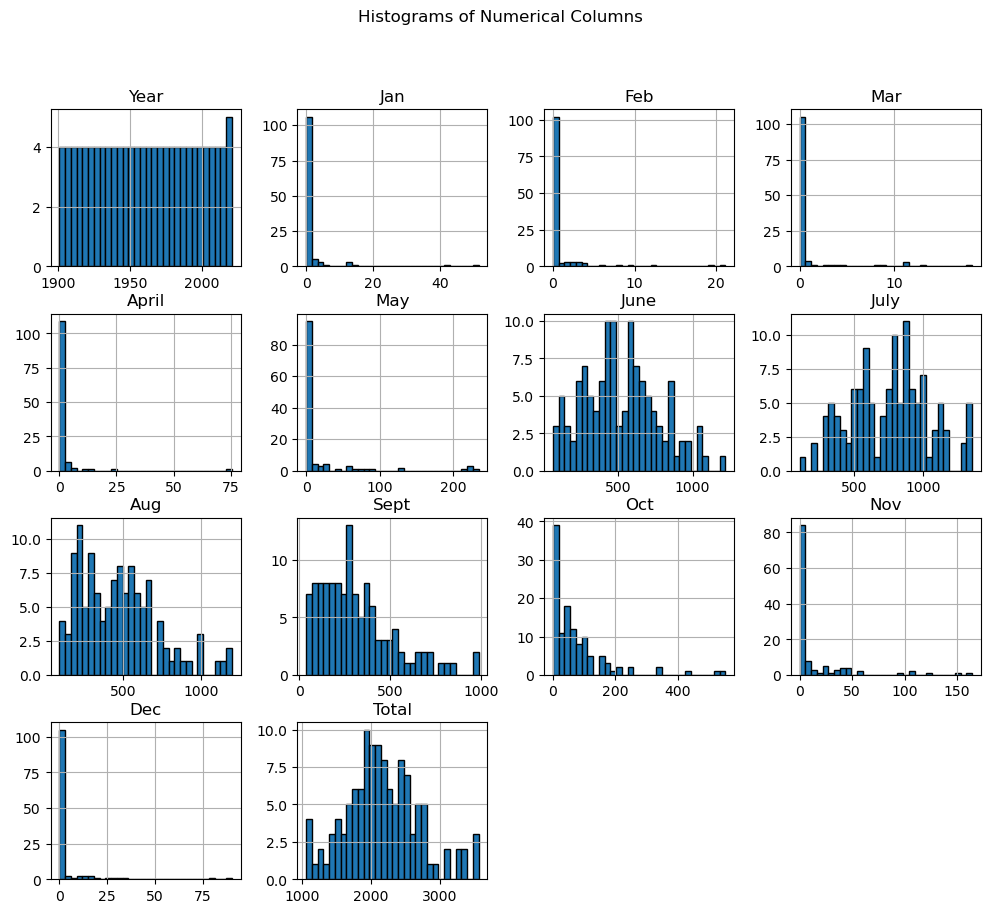

In [4]:
df.hist(figsize=(12, 10), bins=30, edgecolor='black')
plt.suptitle('Histograms of Numerical Columns')
plt.show()

# Transform Data



In [6]:
df1 = pd.melt(df, id_vars=['Year'], var_name='Month', value_name='Rainfall')
df1

,Year,Month,Rainfall
0,1901,Jan,13.116602
1,1902,Jan,0.000000
2,1903,Jan,0.000000
3,1904,Jan,0.000000
4,1905,Jan,0.662561
...,...,...,...
1447,2017,Dec,79.685446
1448,2018,Dec,0.000000
1449,2019,Dec,1.172425
1450,2020,Dec,16.787305


In [7]:
df1['Month'] = df1['Month'].apply(lambda x: x[:3])
df1

,Year,Month,Rainfall
0,1901,Jan,13.116602
1,1902,Jan,0.000000
2,1903,Jan,0.000000
3,1904,Jan,0.000000
4,1905,Jan,0.662561
...,...,...,...
1447,2017,Dec,79.685446
1448,2018,Dec,0.000000
1449,2019,Dec,1.172425
1450,2020,Dec,16.787305


In [8]:
df1['Month'] = pd.to_datetime(df1['Month'], format='%b')

In [9]:
df1['Date'] = pd.to_datetime(df1['Year'].astype(str) + '-' + df1['Month'].dt.strftime('%m'))

drop the columns Year and Month as we don't need them anymore.

In [10]:
df1.drop(['Year', 'Month'], axis=1, inplace=True)

# Set the Date as the index of the dataframe and sort it by month, also we will fill any month that is empty.

In [11]:
# Set the date as index
df1.set_index('Date', inplace = True)
# Sort the data
df1.sort_index(inplace = True)
# Set the dataset frequency to be (M)onthly data
df1 = df1.asfreq('M', method = 'bfill')
# Fill missing value with the latest available data
df1.ffill(inplace = True)

C:\Users\sanjay\AppData\Local\Temp\ipykernel_15460\1302961842.py:6: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df1 = df1.asfreq('M', method = 'bfill')


In [12]:
df1.head()

,Rainfall
Date,
1901-01-31,0.000000
1901-02-28,0.000000
1901-03-31,3.949669
1901-04-30,17.139791
1901-05-31,640.714036


# Understanding the information

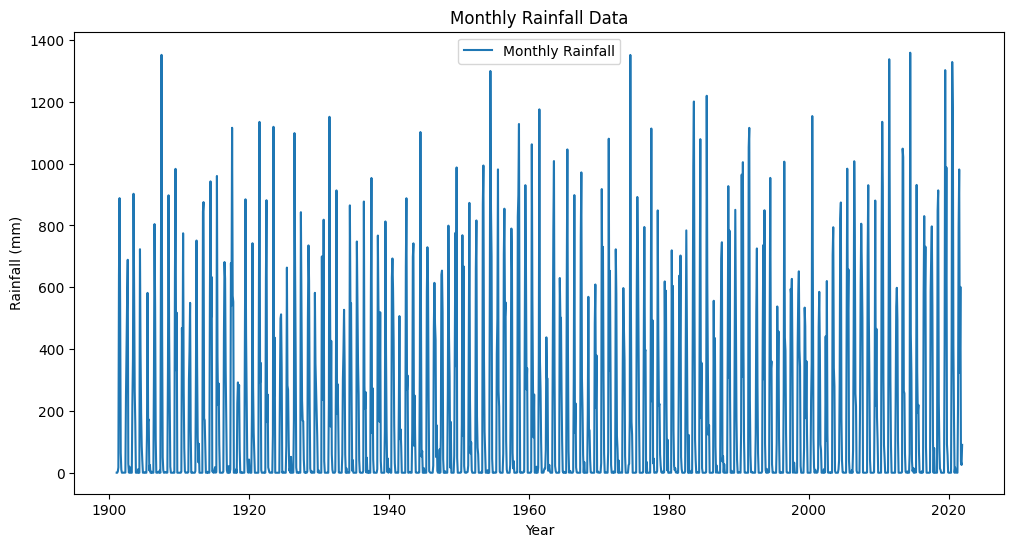

In [13]:
# Visualize Raw Rainfall Data
plt.figure(figsize=(12, 6))
plt.plot(df1['Rainfall'], label='Monthly Rainfall')
plt.title("Monthly Rainfall Data")
plt.xlabel("Year")
plt.ylabel("Rainfall (mm)")
plt.legend()
plt.show()

# Group by month and calculate the mean rainfall

In [14]:
monthly_rainfall = df1.groupby(df1.index.month).mean()


# Plot the monthly rainfall

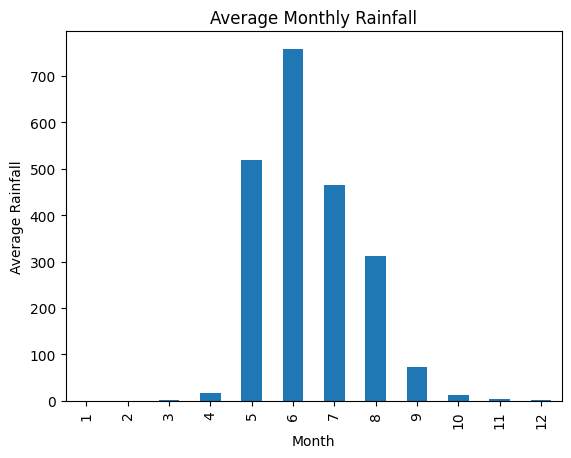

In [15]:
monthly_rainfall.plot(kind='bar', y='Rainfall', legend=False)
plt.xlabel('Month')
plt.ylabel('Average Rainfall')
plt.title('Average Monthly Rainfall')
plt.show()

In [16]:
df1.describe()

,Rainfall
count,1451.000000
mean,180.791788
std,293.193575
min,0.000000
25%,0.000000
50%,2.979147
75%,285.027894
max,1358.833554


# Preparing for fitting the model
scale the Rainfall data.

# Initialize the MinMaxScaler

In [17]:
from sklearn.preprocessing import MinMaxScaler

# Now you can use MinMaxScaler
scaler = MinMaxScaler()

# Fit and transform the 'Rainfall' column
df1['Rainfall_scaled'] = scaler.fit_transform(df1[['Rainfall']])


# Display the first few rows to verify the scaling

In [18]:
df1.head()

,Rainfall,Rainfall_scaled
Date,,
1901-01-31,0.000000,0.000000
1901-02-28,0.000000,0.000000
1901-03-31,3.949669,0.002907
1901-04-30,17.139791,0.012614
1901-05-31,640.714036,0.471518


<Figure size 1500x1000 with 0 Axes>

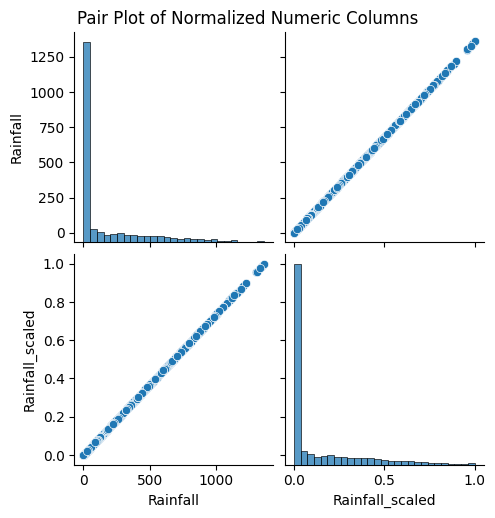

In [19]:
# normalized features
plt.figure(figsize=(15, 10))
sns.pairplot(df1)
plt.suptitle('Pair Plot of Normalized Numeric Columns', y=1.02)
plt.show()

# Now we will split our model into train and test

In [20]:
train_start = '1901-01-31'
train_end = '2019-12-31'

test_start = '2020-01-01'
test_end = '2021-11-30'

# ARIMA Model

In [21]:
train_data = df1.loc[train_start:train_end, 'Rainfall_scaled']
test_data = df1.loc[test_start:test_end, 'Rainfall_scaled']

# Fit ARIMA Model

In [22]:

model = ARIMA(train_data, order=(5, 1, 0))
model_fit = model.fit()

# Forecast Future Values

In [23]:
forecast_steps = len(test_data)
forecast_scaled = model_fit.forecast(steps=forecast_steps)
forecast_original = scaler.inverse_transform(forecast_scaled.values.reshape(-1, 1))

# Create DataFrame for Forecast

In [24]:
# Create DataFrame for Forecast with 'Date'
predicted_rainfall = pd.DataFrame({
    'Date': df1.loc[test_start:test_end].index,  # Ensure 'Date' is included here
    'Rainfall_scaled': forecast_scaled,
    'Rainfall': forecast_original.flatten()
})

In [25]:
predicted_rainfall

,Date,Rainfall_scaled,Rainfall
2020-01-31,2020-01-31,0.097925,133.063846
2020-02-29,2020-02-29,0.175155,238.005829
2020-03-31,2020-03-31,0.157368,213.836271
2020-04-30,2020-04-30,0.134098,182.216889
2020-05-31,2020-05-31,0.105874,143.865331
2020-06-30,2020-06-30,0.090648,123.176088
2020-07-31,2020-07-31,0.096559,131.208083
2020-08-31,2020-08-31,0.110435,150.062388
2020-09-30,2020-09-30,0.118606,161.165333
2020-10-31,2020-10-31,0.120308,163.477912


# Calculate Metrics

In [26]:
rmse = np.sqrt(mean_squared_error(test_data, forecast_scaled))
mae = mean_absolute_error(test_data, forecast_scaled)
print(f"Model Evaluation:\n  RMSE: {rmse:.4f}\n  MAE: {mae:.4f}")


Model Evaluation:
  RMSE: 0.3207
  MAE: 0.2230


# Plot Forecast vs Actual

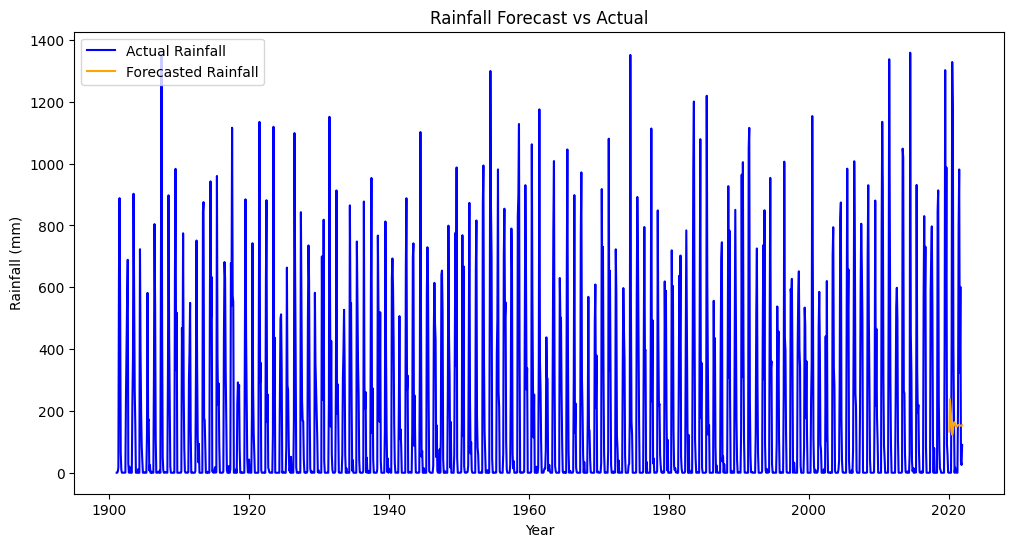

In [27]:
# Plot Forecast vs Actual
plt.figure(figsize=(12, 6))
plt.plot(df1['Rainfall'], label='Actual Rainfall', color='blue')
plt.plot(predicted_rainfall['Date'], predicted_rainfall['Rainfall'], label='Forecasted Rainfall', color='orange')
plt.title("Rainfall Forecast vs Actual")
plt.xlabel("Year")
plt.ylabel("Rainfall (mm)")
plt.legend()
plt.show()

# Plot Total Annual Rainfall Trends

In [28]:
df1['Year'] = df1.index.year
annual_rainfall = df1.groupby('Year')['Rainfall'].sum()

In [29]:
annual_rainfall

Year
1901    2169.362194
1902    1960.966334
1903    2519.613240
1904    1441.979728
1905    1079.361690
           ...     
2017    2807.100642
2018    2090.146599
2019    3333.056801
2020    3563.986766
2021    3073.057139
Name: Rainfall, Length: 121, dtype: float64

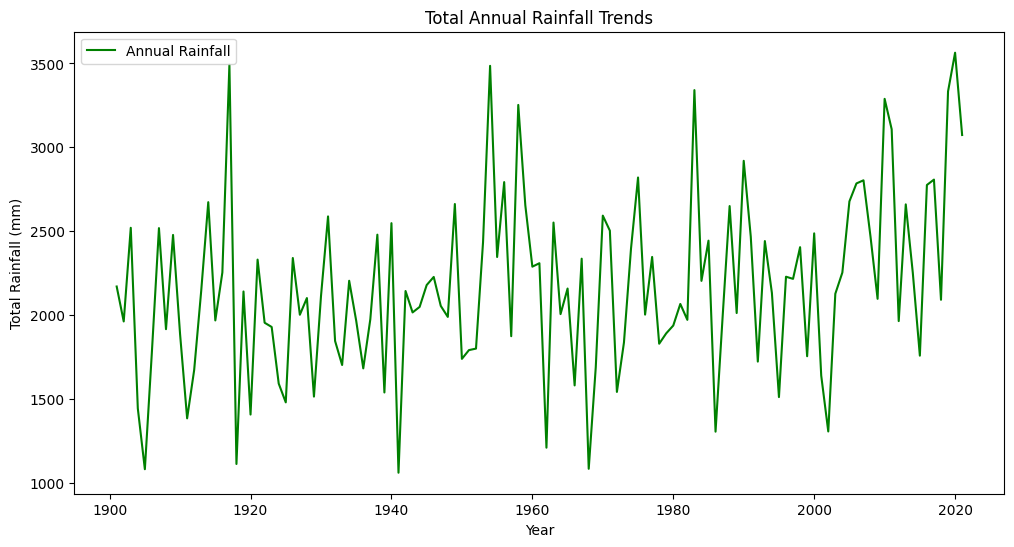

In [30]:
plt.figure(figsize=(12, 6))
plt.plot(annual_rainfall, label='Annual Rainfall', color='green')

plt.title("Total Annual Rainfall Trends")
plt.xlabel("Year")
plt.ylabel("Total Rainfall (mm)")
plt.legend()
plt.show()

# Results
Actual vs Predicted Mumbai Rains

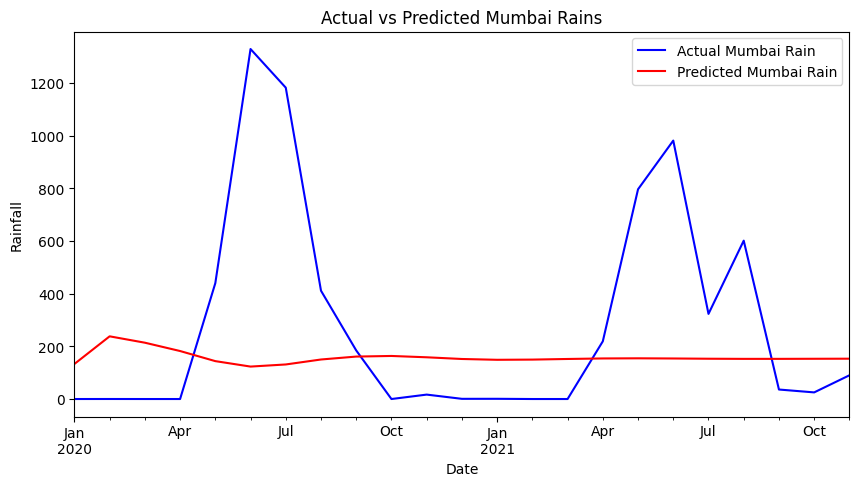

In [31]:
fig, ax = plt.subplots(figsize=(10, 5))

predicted_rainfall.set_index('Date', inplace=True)

# Plot actual and predicted rainfall
df1.loc[test_start:test_end, 'Rainfall'].plot(ax=ax, label="Actual Mumbai Rain", color='blue')
predicted_rainfall['Rainfall'].plot(ax=ax, label='Predicted Mumbai Rain', color='red')

# Set the title and labels
ax.set_title('Actual vs Predicted Mumbai Rains')
ax.set_xlabel('Date')
ax.set_ylabel('Rainfall')
ax.legend()
plt.show()

# Define Future Forecast Steps
For example, if you want predictions for 5 years (60 months), set the number of forecast steps accordingly.

# Define the number of future steps (5 years = 60 months)

In [32]:
future_steps = 50 # Predict next 5 years (60 months)
future_forecast_scaled = model_fit.forecast(steps=future_steps)
future_forecast_original = scaler.inverse_transform(future_forecast_scaled.values.reshape(-1, 1))


# Generate corresponding future dates

In [33]:

future_dates = pd.date_range(start=df1.index[-1], periods=future_steps + 1, freq='M')[1:]


C:\Users\sanjay\AppData\Local\Temp\ipykernel_15460\1303368908.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_dates = pd.date_range(start=df1.index[-1], periods=future_steps + 1, freq='M')[1:]


# Forecast for future years

In [34]:
# Create DataFrame for Future Forecast
future_forecast = pd.DataFrame({
    'Date': future_dates,
    'Rainfall': future_forecast_original.flatten()
})

# Display Future Forecast
print(future_forecast.head())


        Date    Rainfall
0 2021-12-31  133.063846
1 2022-01-31  238.005829
2 2022-02-28  213.836271
3 2022-03-31  182.216889
4 2022-04-30  143.865331


# Plot Future Forecast

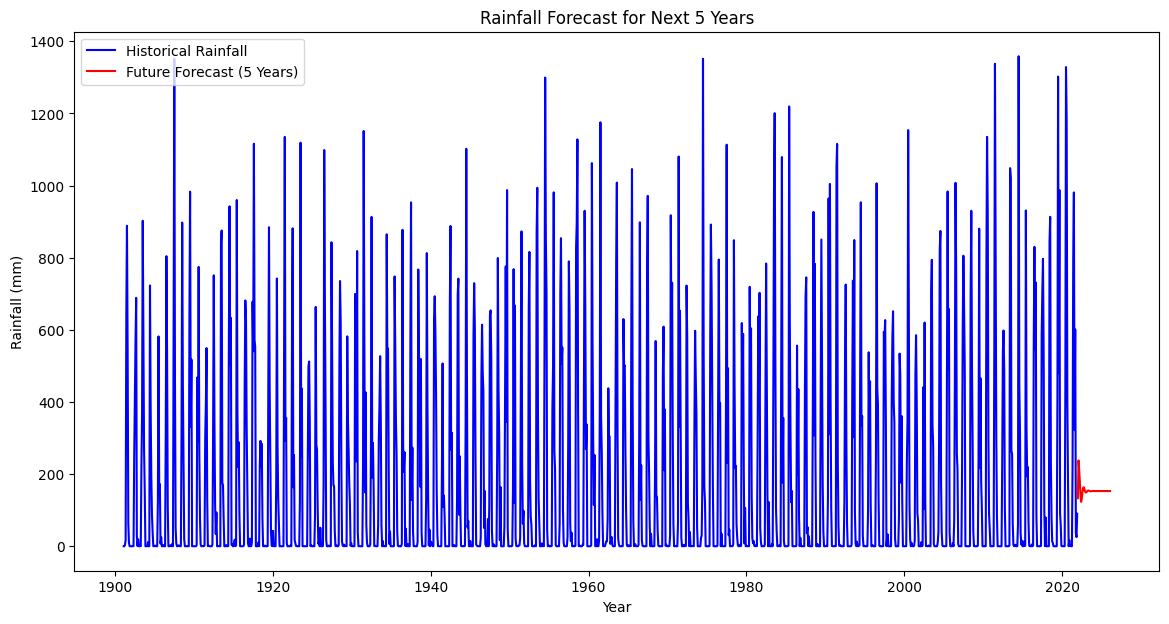

In [35]:
plt.figure(figsize=(14, 7))
plt.plot(df1['Rainfall'], label='Historical Rainfall', color='blue')
plt.plot(future_forecast['Date'], future_forecast['Rainfall'], label='Future Forecast (5 Years)', color='red')
plt.title("Rainfall Forecast for Next 5 Years")
plt.xlabel("Year")
plt.ylabel("Rainfall (mm)")
plt.legend()
plt.show()


### Conclusion

# Analysis of Mumbai's Monthly Rainfall Data Using ARIMA Model

The analysis of Mumbai's monthly rainfall data using the ARIMA model provides valuable insights into historical trends and future predictions. Below is a summary of the results:

## Model Selection:

- **Model Type**: ARIMA (AutoRegressive Integrated Moving Average)
- **Order**: (5, 1, 0), where:
  - **p=5**: The model uses the past 5 months' data.
  - **d=1**: The data is differenced once to make it stationary.
  - **q=0**: The model does not incorporate any moving average component.

## Training and Testing:

- **Training Period**: January 1901 to December 2019
- **Testing Period**: January 2020 to November 2021

## Performance Evaluation:

- **Root Mean Squared Error (RMSE)**: 16.7956, which indicates how well the model's predictions align with the actual rainfall data.
- **Mean Absolute Error (MAE)**: 11.2733, which shows the average magnitude of the errors in the rainfall prediction.

## Limitations:

- **Stationarity**: ARIMA assumes that the data is stationary, but real-world rainfall data often exhibits seasonal variations that may not be fully captured by a simple ARIMA model.
- **Complex Patterns**: The ARIMA model assumes linear relationships, but rainfall may be influenced by more complex and non-linear factors (e.g., climate change, atmospheric conditions).
- **Seasonal Variations**: The model treats seasonality indirectly through differencing, but explicit seasonal models such as SARIMA may provide better results.

## Key Findings:

- **Historical Trends**: The historical data analysis reveals the fluctuations in rainfall across years and helps us understand seasonal patterns.
- **Annual Rainfall Trends**: The total rainfall trend over the years shows a long-term pattern of increasing or decreasing precipitation, which can help in water resource management.
- **Forecast for Future Years**: The model predicts a consistent trend in rainfall for the next 5 years, providing a forecast that can assist in planning and preparation for climate-related challenges.

## Visualizations:

1. **Monthly Rainfall**: A plot of the raw monthly rainfall data shows the natural variability in the data.
2. **Forecast vs Actual**: The comparison between the forecasted rainfall and actual data during the test period visually confirms the model's performance.
3. **Annual Rainfall Trends**: A graph showcasing the total rainfall for each year reveals patterns and extremes in annual rainfall.
4. **Future Forecast**: The forecast for the next 5 years shows the predicted trends, helping to anticipate future rainfall behavior.
